In [1]:
import numpy as np
import pandas as pd

from pymatch.Matcher import Matcher

In [2]:
import sys
def drop_static_cols(df, yvar, cols=None):
    if not cols:
        cols = list(df.columns)
    # will be static for both groups
    cols.pop(cols.index(yvar))
    for col in df[cols]:
        n_unique = len(np.unique(df[col]))
        if n_unique == 1:
            df.drop(col, axis=1, inplace=True)
            sys.stdout.write('\rStatic column dropped: {}'.format(col))
    return df

## Load SZ data

In [3]:
p_pheno = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/pheno_26-01-22.csv'
p_conn = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/connectomes_01-12-21.csv'

pheno = pd.read_csv(p_pheno,index_col=0)
conn = pd.read_csv(p_conn,index_col=0)

/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
conf = ['AGE','SEX','SITE','mean_conn','FD_scrubbed']

con_sz = pheno[(pheno['CON_IPC'] == 1)&(pheno['PI'].isin(pheno[pheno['SZ'] == 1]['PI'].unique()))][conf + ['SZ']]
case_sz = pheno[pheno['SZ']==1][conf + ['SZ']]

con_sz.loc[:,'SZ'] = con_sz.loc[:,'SZ'].astype(int)
case_sz.loc[:,'SZ'] = case_sz.loc[:,'SZ'].astype(int)

#con_sz = pd.get_dummies(con_sz,['SEX','SITE'])
#case_sz = pd.get_dummies(case_sz,['SEX','SITE'])

In [5]:
case_sz.dtypes

AGE            float64
SEX             object
SITE            object
mean_conn      float64
FD_scrubbed    float64
SZ               int64
dtype: object

In [6]:
#formula = "SZ ~ AGE+C(SEX)+C(SITE)+mean_conn+FD_scrubbed"

m = Matcher(case_sz,con_sz,yvar='SZ',
#    formula=formula
    )

Formula:
Q('SZ') ~ Q('AGE')+Q('FD_scrubbed')+Q('SEX')+Q('SITE')+Q('mean_conn')
n majority: 355
n minority: 283


In [7]:
m.data

,AGE,FD_scrubbed,SEX,SITE,SZ,mean_conn,og_idx
0,40.0,0.255986,Male,UCLA_DS1,1,0.317357,sub_50005
1,47.0,0.113656,Female,UCLA_DS1,1,0.528993,sub_50007
2,41.0,0.209010,Male,UCLA_DS1,1,0.208092,sub_50010
3,30.0,0.175190,Male,UCLA_DS1,1,0.461330,sub_50013
4,22.0,0.200607,Male,UCLA_DS1,1,0.346376,sub_50014
...,...,...,...,...,...,...,...
633,30.0,0.090000,Male,SZ8,0,0.345056,szipraCM14AAY
634,24.0,0.210000,Male,SZ8,0,0.302343,szipraCM17ER
635,34.0,0.110000,Male,SZ8,0,0.279566,szipraCM24FL
636,39.0,0.150000,Male,SZ8,0,0.680780,szipraCM32JJ


In [8]:
#import patsy
#import statsmodels as sm
#from pymatch import *

#formula = "SZ ~ AGE+C(SEX)+C(SITE)+mean_conn+FD_scrubbed"

#df = m.balanced_sample()
#df = pd.concat([drop_static_cols(df[df[m.yvar] == 1], yvar=m.yvar),
#                                drop_static_cols(df[df[m.yvar] == 0], yvar=m.yvar)],
#                               sort=True)

#y_samp, X_samp = patsy.dmatrices(formula, data=df, return_type='dataframe')
#X_samp.drop(m.yvar, axis=1, errors='ignore', inplace=True)
#glm = GLM(y_samp, X_samp, family=sm.families.Binomial())

In [9]:
#res = glm.fit()

#preds = [[1.0 if i >= .5 else 0.0 for i in res.predict(X_samp)]]
#out = (y_samp.to_numpy().T == preds).sum() * 1.0 / len(y_samp)

#m._scores_to_accuracy(res, X_samp, y_samp)

In [10]:
# for reproducibility
np.random.seed(1)

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 66.15%


In [11]:
#scores = np.zeros(len(m.X))
#for i in range(m.nmodels):
#mmm = m.models[0]
#mmm.predict(m.X[mmm.params.index])
#m.data['scores'] = scores/m.nmodels
#m.X.columns
#mmm.params.index

In [12]:
m.predict_scores()

/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


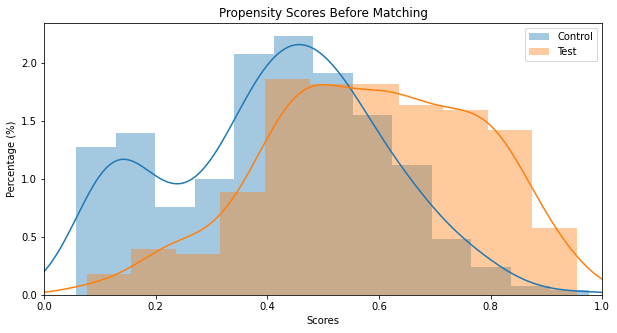

In [13]:
m.plot_scores()

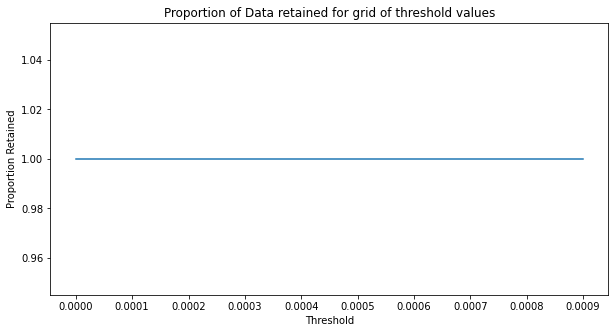

In [14]:
m.tune_threshold(method='min')

In [15]:
m.match(method="min", nmatches=1, threshold=0.0009)

In [16]:
m.record_frequency()

,freq,n_records
0,1,363
1,2,33
2,3,9
3,4,10
4,5,4
5,6,3
6,9,1
7,11,1
8,12,1


In [17]:
m.assign_weight_vector()

In [18]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,AGE,FD_scrubbed,SEX,SITE,SZ,mean_conn,og_idx,scores,match_id
0,0,1.0,40.0,0.255986,Male,UCLA_DS1,1,0.317357,sub_50005,0.608770,0
421,493,1.0,30.0,0.090000,Male,SZ9,0,0.257667,scrave16,0.609011,0
1,1,1.0,47.0,0.113656,Female,UCLA_DS1,1,0.528993,sub_50007,0.090284,1
300,354,1.0,26.0,0.108082,Male,UCLA_DS1,0,0.522769,sub_10844,0.090260,1
2,2,1.0,41.0,0.209010,Male,UCLA_DS1,1,0.208092,sub_50010,0.500802,2
313,398,1.0,44.0,0.120000,Female,SZ5,0,0.317533,sA00036135,0.500624,2


In [20]:
m.matched_data

,record_id,weight,AGE,FD_scrubbed,SEX,SITE,SZ,mean_conn,scores,match_id
0,0,1.000000,40.0,0.255986,Male,UCLA_DS1,1,0.317357,0.608770,0
1,1,1.000000,47.0,0.113656,Female,UCLA_DS1,1,0.528993,0.090284,1
2,2,1.000000,41.0,0.209010,Male,UCLA_DS1,1,0.208092,0.500802,2
3,3,1.000000,30.0,0.175190,Male,UCLA_DS1,1,0.461330,0.241435,3
4,4,1.000000,22.0,0.200607,Male,UCLA_DS1,1,0.346376,0.374856,4
...,...,...,...,...,...,...,...,...,...,...
561,634,0.083333,24.0,0.210000,Male,SZ8,0,0.302343,0.840940,266
562,635,1.000000,34.0,0.110000,Male,SZ8,0,0.279566,0.563939,119
563,636,0.333333,39.0,0.150000,Male,SZ8,0,0.680780,0.477982,186
564,636,0.333333,39.0,0.150000,Male,SZ8,0,0.680780,0.477982,198


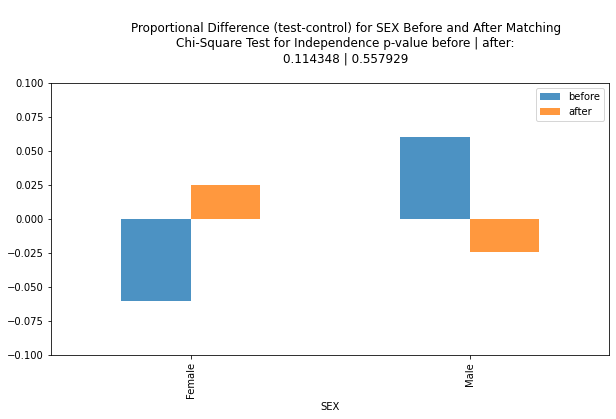

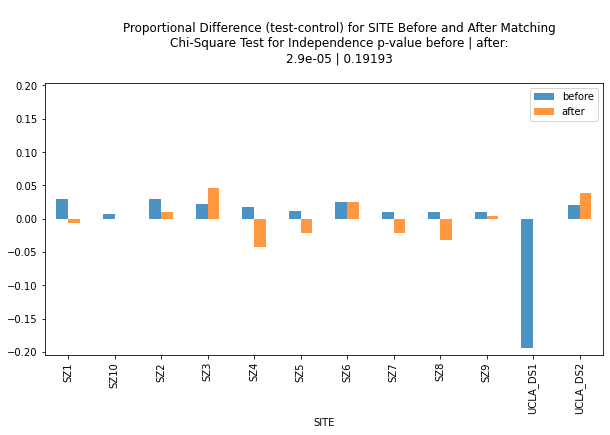

In [49]:
categorical_results = m.compare_categorical(return_table=True)

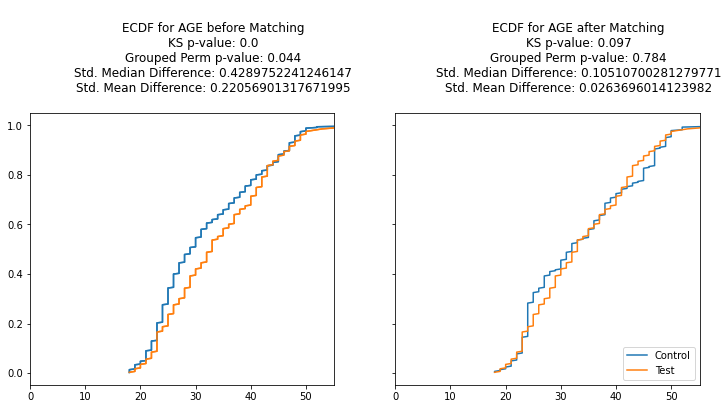

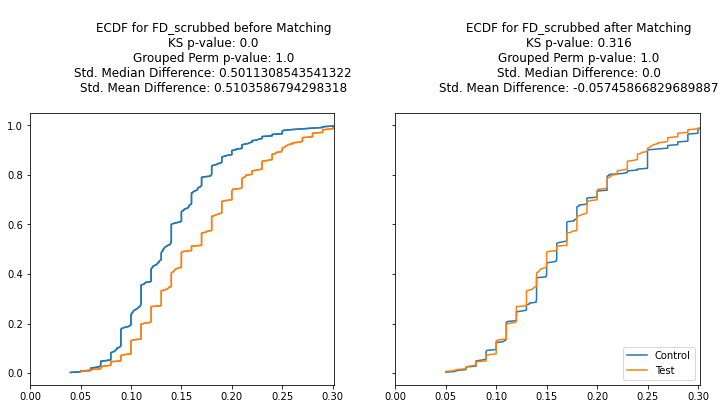

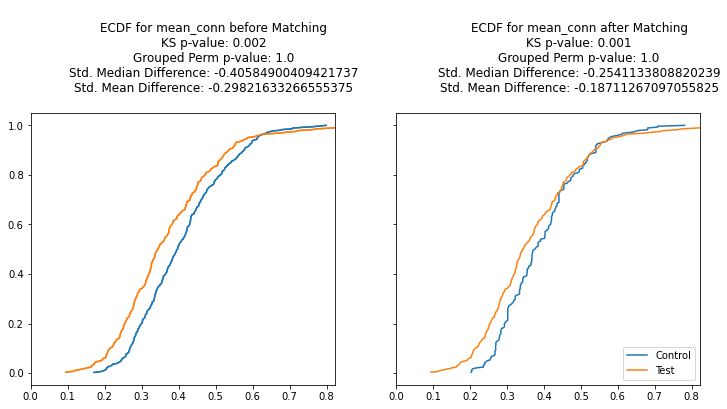

In [50]:
cc = m.compare_continuous(return_table=True)

In [51]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,AGE,0.000,0.097,0.044,0.784,0.428975,0.105107,0.220569,0.026370
1,FD_scrubbed,0.000,0.316,1.000,1.000,0.501131,0.000000,0.510359,-0.057459
2,mean_conn,0.002,0.001,1.000,1.000,-0.405849,-0.254113,-0.298216,-0.187113
